In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
print(tf.version.VERSION)

2.3.0


In [7]:
import sys
sys.version

'3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]'

In [8]:
print(keras.__version__)

2.4.0


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
IMAGE_SIZE=[128, 128]
EPOCHS = 20
BATCH_SIZE = 64

In [21]:
pth = 'E:/_DOWNLOADED/'
img_pth = 'E:/_DOWNLOADED/archive/'

train_df_main  = pd.read_csv(os.path.join(pth, 'train_df.csv'))


train_df_main .drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main .columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [22]:
train_df_main['FilePath'] = train_df_main['FilePath'].str.replace('../input/data','E:/_DOWNLOADED/archive')
train_df_main['FilePath'].sample(10)

82518     E:/_DOWNLOADED/archive/images_009/images/00020...
38695     E:/_DOWNLOADED/archive/images_005/images/00010...
31177     E:/_DOWNLOADED/archive/images_004/images/00008...
39973     E:/_DOWNLOADED/archive/images_005/images/00010...
21796     E:/_DOWNLOADED/archive/images_003/images/00005...
81447     E:/_DOWNLOADED/archive/images_009/images/00020...
67768     E:/_DOWNLOADED/archive/images_008/images/00016...
23099     E:/_DOWNLOADED/archive/images_003/images/00006...
85345     E:/_DOWNLOADED/archive/images_010/images/00021...
101484    E:/_DOWNLOADED/archive/images_011/images/00026...
Name: FilePath, dtype: object

In [23]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model
import tensorflow.keras.layers as L

In [26]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
   
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [27]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [28]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])


getting train generator...
Found 21526 validated image filenames.
getting train and valid generators...
Found 21526 validated image filenames.
Found 5382 validated image filenames.
Found 6728 validated image filenames.


In [6]:
from tensorflow import keras
keras.backend.clear_session()

In [3]:
# from tensorflow.keras.applications import ResNet50
# res_model = ResNet50()
# res_model.summary()

In [29]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3),padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64,(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(14))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3936320   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [33]:
optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=12,
                    validation_data=valid_generator)

Epoch 1/12
337/337 [==============================] - 433s 1s/step - loss: 6.3284 - accuracy: 0.0148 - val_loss: 6.4628 - val_accuracy: 0.0227
Epoch 2/12
337/337 [==============================] - 403s 1s/step - loss: 6.8134 - accuracy: 0.0128 - val_loss: 3.7166 - val_accuracy: 0.0098
Epoch 3/12
337/337 [==============================] - 402s 1s/step - loss: 4.4553 - accuracy: 0.0277 - val_loss: 3.7166 - val_accuracy: 0.0227
Epoch 4/12
337/337 [==============================] - 400s 1s/step - loss: 3.7711 - accuracy: 0.0259 - val_loss: 3.7166 - val_accuracy: 0.0227
Epoch 5/12
337/337 [==============================] - 392s 1s/step - loss: 5.2236 - accuracy: 0.0264 - val_loss: 8.5442 - val_accuracy: 0.0227
Epoch 6/12
337/337 [==============================] - 504s 1s/step - loss: 7.3130 - accuracy: 0.0245 - val_loss: 8.5442 - val_accuracy: 0.0227
Epoch 7/12
337/337 [==============================] - 401s 1s/step - loss: 6.6958 - accuracy: 0.0253 - val_loss: 8.5442 - val_accuracy: 0.0227

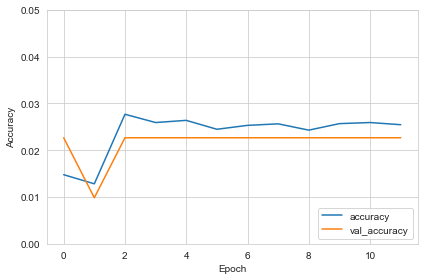

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.05])
plt.legend(loc='lower right')
plt.tight_layout()

In [37]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

106/106 - 97s - loss: 3.5097 - accuracy: 0.0226
